# 一、用代码实现马尔科夫链

全文约定：转移概率矩阵P的第 ***i*** 行的每个元素，表示从第 ***i*** 个状态迁移到状态空间中其他状态的概率，即:
 <big> $$P_{ij}=P(x_i, x_j)=P\{X_{t+1} = x_j | X_t = x_i\}， 其中  (x_i, x_j ∈ S)， S为状态空间$$ </big>

## 1.1、示意代码

In [1]:
using QuantEcon

In [2]:
function mc_sample(P_init; init=1, sample_size=1000)
    X = Array(Int64, sample_size) # alloc memory
    X[1] = init # push init state
    
    # == 把初始转移概率矩阵P_init的每一行都转换为一个离散分布（Discrete distribution） == #
    # == 则P_dist的每个元素 i，分别表示状态 i 的转移概率分布
    n = size(P_init)[1]
    P_dist = [DiscreteRV(vec(P_init[i,:])) for i in 1:n]
    
    # == 根据P_dist中状态 i 的概率分布，随机选择下一个状态，填充到结果X中 == #
    for t in 1:(sample_size - 1)
        X[t+1] = draw(P_dist[X[t]])
    end
    
    return X
end

mc_sample (generic function with 1 method)

In [3]:
# 假设有 2 个状态（1，2），对应的转移概率矩阵如下P_init
P_init = [0.4 0.6;
          0.2 0.8]
mc_sample(P_init, sample_size=10)

10-element Array{Int64,1}:
 1
 2
 1
 2
 1
 1
 1
 2
 2
 2

## 1.2、 使用库函数

In [4]:
mc = MarkovChain(P_init)
simulate(mc, 10)

10-element Array{Int64,1}:
 2
 2
 2
 2
 2
 2
 2
 1
 2
 1

In [5]:
# 有具体名称的状态
mc2 = MarkovChain(P_init, ["employed", "unemployed"])
simulate(mc2, 5, init=1) # 假设初始状态是 "employed"

5-element Array{String,1}:
 "employed"  
 "unemployed"
 "unemployed"
 "unemployed"
 "unemployed"

# 二、平稳分布 Stationary Distributions
若转移概率矩阵为P，其平稳分布 ***V***($1 * N$ 向量，第 **i** 个元素为状态 **i** 的占比，所有元素之和为1)满足：
$$V = VP $$

平稳分布的计算，可以用：
- 迭代法
- 特征向量（特征值为1的特征向量）
- 代数计算

下面通过画图直观的感受一下转移矩阵随着迭代趋近于平稳分布。

In [6]:
using Plots
pyplot()
Plots.PyPlotBackend()

Plots.PyPlotBackend()

In [7]:
# v_init 是初始概率分布
function simStationaryDist()
    # 构造一个转移概率矩阵
    P =[0.971 0.029 0.000
        0.145 0.778 0.077
        0.000 0.508 0.492]
    
    # 假设一个初始状态概率分布
    psi = [0.0 0.2 0.8]
    
    t = 20
    x_vals = Array(Float64, t+1)
    y_vals = Array(Float64, t+1)
    z_vals = Array(Float64, t+1)
    colors = []
    
    for i=1:t
        x_vals[i] = psi[1]
        y_vals[i] = psi[2]
        z_vals[i] = psi[3]
        psi = psi*P
        push!(colors, :red)
    end
    push!(colors, :black)

    # 计算平稳分布，并作为最后一个点，用黑色显示
    mc = MarkovChain(P)
    psi_star = stationary_distributions(mc)[1]
    x_vals[t+1] = psi_star[1]
    y_vals[t+1] = psi_star[2]
    z_vals[t+1] = psi_star[3]
    scatter(x_vals, y_vals, z_vals, color=colors)
    plot!(lims=(0, 1), legend=:none)
end

simStationaryDist (generic function with 1 method)


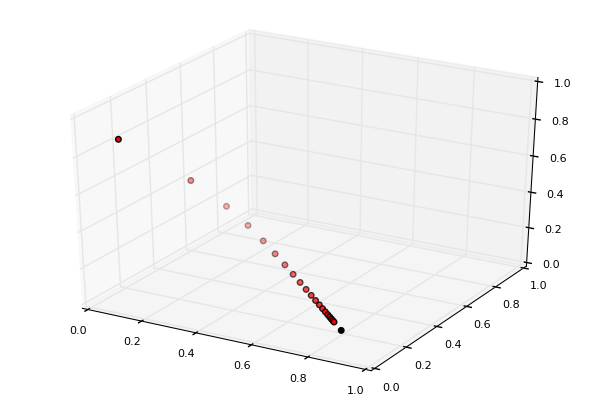

In [8]:
simStationaryDist()

# 三、极限分布

对一个不可约性的Markov过程，当 $n \to \infty$ 时，满足：
$$ \frac{1}{n}\sum_{t=1}^{n}1\{X_t = x\} \to V(x) $$

- $ 1\{X_t = x\} $ 表示当 $X_t$ == x 时取值为1，否则取值为0
- 该极限必然存在，且平稳分布就是一个合法的极限

下面用一个实际的例子，画图来直观感受一下。

假设一个Markov过程有两个状态{1, 2}, 其转移概率矩阵为：

  $$ P = \left( \begin{array}{cc}
1-a & a \\
b & 1-b \end{array} \right) $$
  
可以计算得到状态 1 的稳定分布为：
  $$ V_1 = \frac{b}{a + b} $$

不妨取 a = b = 0.1。计算随着迭代次数增加，状态 1 的极限分布和平稳分布的差值变化情况，并画图。

In [9]:
using LaTeXStrings

function simDiff()
    a = b = 0.1
    N = 10000 # 迭代次数
    v1 = b / (a + b)

    P = [1-a a
         b  1-b]
    
    mc = MarkovChain(P)
    
    labels = []
    y_vals = []
    
    for x0 = 1:2
        X = simulate_indices(mc, N; init=x0)
        
        y_bar = cumsum(X .== 1) ./ (collect(1:N))
        
        push!(labels, LaTeXString("\$X_0 = $x0\$"))
        push!(y_vals, y_bar - v1)
    end
    
    plot(y_vals, fillrange=0, fillalpha=0.1,
    ylims=(-0.25, 0.25), label=labels')
end

simDiff (generic function with 1 method)


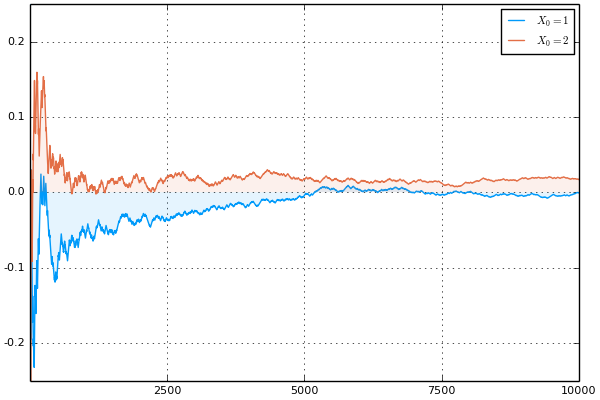

In [13]:
simDiff()

# 四、PageRank

PageRank对网页排名的算法，曾是Google发家致富的法宝。PageRank算法计算每一个网页的PageRank值，然后根据这个值的大小对网页的重要性进行排序。

## 4.1 最简单的算法
首先，将Web做如下抽象：
- 将每个网页抽象成一个节点；
- 如果一个页面A有链接直接链向B，则存在一条有向边从A到B（多个相同链接不重复计算边）。

因此，整个Web被抽象为一张有向图。现在假设世界上只有四张网页：A、B、C、D，其抽象结构如下图：
![有向图](image/1.png)

PageRank算法基本思想：被用户访问**越多**的网页更可能**质量越高**，而用户在浏览网页时主要通过超链接进行页面跳转，因此需要通过分析超链接组成的拓扑结构来推算每个网页被访问频率的高低。最简单的，我们可以**假设**当一个用户停留在某页面时，跳转到页面上每个被链页面的**概率相同**。

例如，上图中A页面链向B、C、D，所以一个用户从A跳转到B、C、D的概率各为1/3。显然这是一个转移矩阵。下面是上图的转移矩阵P：
$$ P = \left( \begin{array}{cc}
0           & \frac{1}{3} & \frac{1}{3} & \frac{1}{3} \\
\frac{1}{2} &       0     & \frac{1}{2} & 0 \\
0           &       0     &     0       & 1 \\
\frac{1}{2} & \frac{1}{2} &     0       & 0
\end{array} \right) $$

若 $P$ 的稳定分布 $V$ 存在（$ V = VP $），则 $V$ 就是最终的Rank值。

## 4.2 其他问题
- 一个没有链接的页面，会导致Markov过程终止
- 一个永远链接到自己的页面，会导致Markov死循环
- 用户可能不点链接，而是自己在导航栏输入一个新网址

思路：选择下一个页面时，考虑一定概率的跳转到本页面没有的链接（用户自己输入）。

假设跳转到当前页面（包括当前页面上的链接）的概率为 $a$（也称为**基尼系数**），那么跳转到其他页面概率为 $(1−a)$，进一步假设每个页面被随机访问的概率相同都是 $\frac{1}{N}$(N是网页总数)，于是新的转移矩阵为：
$$ P' = aP + \frac{(1-a)}{N}e^Te $$

其中e为 $1*N$ 行向量 $e = \{1, 1, \cdots, 1\}$。

可以证明，$P'$ 是一个转移矩阵，且满足不可约和非周期性，因此存在稳定分布。

## 4.3 计算一个例子
假设有如下图的一个网络：
![有向图2](image/2.png)

将其链接关系（格式见下）存储到文件web_graph_data.txt中。


In [11]:
"""
数据格式
a -> d;
a -> f;
b -> j;
b -> k;
b -> m;
c -> c;
c -> g;
c -> j;
c -> m;
d -> f;
d -> h;
d -> k;
e -> d;
e -> h;
e -> l;
f -> a;
f -> b;
f -> j;
f -> l;
g -> b;
g -> j;
h -> d;
h -> g;
h -> l;
h -> m;
i -> g;
i -> h;
i -> n;
j -> e;
j -> i;
j -> k;
k -> n;
l -> m;
m -> g;
n -> c;
n -> j;
n -> m;
"""
function myPageRank()
    alphabet = "abcdefghijklmnopqrstuvwxyz"
    
    a = 0.85 # 基尼系数
    n = 14   # 节点（页面）总数
    
    # == 矩阵Q存储页面链接关系== #
    #  * Q[i, j] = 1 表示存在一个 i 到 j 的链接
    #  * Q[i, j] = 0 不存在链接
    Q = zeros(Int64, n, n)

    f = open("web_graph_data.txt", "r")
    links = readlines(f)
    close(f)
    for link in links
        from_node, to_node = matchall(r"\w", link)
        i = searchindex(alphabet, from_node)
        j = searchindex(alphabet, to_node)
        Q[i, j] = 1
    end
    
    # == 创建转移概率矩阵 == #
    P = Array(Float64, n, n)
    for i=1:n
        P[i, :] = a * Q[i, :] / sum(Q[i, :]) + (1 - a)/n
    end
    
    mc = MarkovChain(P)

    # == 计算平稳分布 == #
    V = stationary_distributions(mc)[1]
    
    # == 构造一个 页面名称 -> 页面分布概率 的映射关系
    ranked_pages = Dict(alphabet[i] => V[i] for i=1:n)

    # == 输出结果，按照Rank来排序 == #
    println("Rankings\n ***")
    sort_inds = reverse!(sortperm(collect(values(ranked_pages))))
    the_keys = collect(keys(ranked_pages))
    the_vals = collect(values(ranked_pages))
    for i in sort_inds
        @printf("%s: %.4f\n", the_keys[i], the_vals[i])
    end
end

myPageRank

In [12]:
myPageRank()

Rankings
 ***
g: 0.1466
j: 0.1398
m: 0.1181
n: 0.0973
k: 0.0851
b: 0.0794
h: 0.0515
e: 0.0503
i: 0.0503
c: 0.0486
d: 0.0432
l: 0.0423
f: 0.0302
a: 0.0171


# 五、参考文献
- https://lectures.quantecon.org/jl/finite_markov.html Finite Markov Chains
- http://blog.csdn.net/rubinorth/article/details/52215036 PageRank算法--从原理到实现
- http://blog.jobbole.com/71431/ PageRank算法简介及Map-Reduce实现
- http://blog.csdn.net/ZCF1002797280/article/details/50254069 PageRank算法原理剖析及Spark实现
- http://blog.csdn.net/wzy0623/article/details/51383232 PageRank算法在spark上的简单实现
- http://www.ppvke.com/Blog/archives/36921 一文搞懂HMM（隐马尔可夫模型）
- http://blog.csdn.net/google19890102/article/details/51755242 简单易学的机器学习算法——马尔可夫链蒙特卡罗方法MCMC